In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

a = 1/120
b = 1/120

l = np.pi

alpha, beta  = 1, -1
gamma, delta = 1, -1

get_left_bound = lambda t : -1 * np.exp(-a*t) * (np.cos(b*t) + np.sin(b*t))
get_right_bound = lambda t : np.exp(-a*t) * (np.cos(b*t) + np.sin(b*t))
get_initial_values = lambda x : np.cos(x)

analit_function = lambda x, t : np.exp(-a*t) * np.cos(x + b*t)

In [2]:
def solve_explicit(*, space_start=0.0, space_stop=1.0, space_num=200,
                      time_start=0.0,  time_stop=1.0,  time_num=200):
    space_step = (space_stop - space_start) / (space_num - 1)
    time_step = (time_stop - time_start) / (time_num - 1)
    
    grid = np.zeros((time_num, space_num))
    grid[0, :] = get_initial_values( np.linspace(space_start, space_stop, space_num) )
    
    for t in range(time_num - 1):
        for x in range(1, space_num - 1):
            coef = a * time_step / (space_step*space_step)
            diffusion = coef * ( grid[t, x+1] - 2*grid[t, x] + grid[t, x-1] )
            
            coef = b * time_step / (2*space_step)
            movement = coef * ( grid[t, x+1] - grid[t, x] )
            
            grid[t+1, x] = grid[t, x] + diffusion + movement
        
        grid[t+1, 0] =  ( -1 * (alpha / space_step) * grid[t+1, 1] + get_left_bound((t+1) * time_step) ) / (beta - alpha / space_step)
        grid[t+1, -1] = ( (gamma / space_step) * grid[t+1, -2] + get_right_bound((t+1) * time_step) ) / (delta + gamma / space_step)
        
    return grid

In [3]:
grid = solve_explicit(space_start=0.0, space_stop=l, space_num=10, time_num=200)

In [4]:
grid[0]

array([ 1.    ,  0.9397,  0.766 ,  0.5   ,  0.1736, -0.1736, -0.5   ,
       -0.766 , -0.9397, -1.    ])

In [5]:
grid[-1]

array([ 0.9459,  0.9271,  0.7565,  0.492 ,  0.1681, -0.1761, -0.499 ,
       -0.7615, -0.9253, -0.8853])

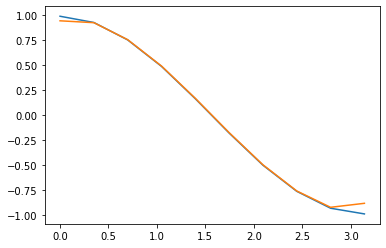

In [6]:
points = np.linspace(0.0, l, 10)
plt.plot(points, analit_function(points, 1))
plt.plot(points, grid[-1])

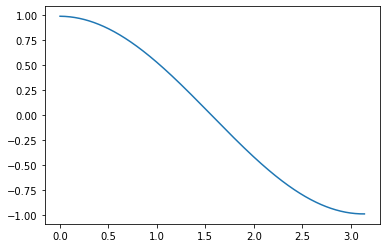

In [7]:
points = np.linspace(0.0, l, 500)
plt.plot(points, analit_function(points, 1))